CSPI
ターゲットクラスをそのインスタンスの正解クラスとする。

全ての特徴量の部分集合（2^N）に対して、特性関数 v(S) を定義し、

v(S) = 1 if 出力クラスがターゲットクラス

v(S) = 0 otherwise

Shapley値の定義に従って、特徴量の貢献度を正確に計算。

SSPIという名前はpivotに基づくものだったため、
これを「CSPI（Class-wise Shapley Attribution）」へ改名。

ex. N=[a,b,c,d], Y=[A,B,C]の場合
1. instance=0で、予測クラスpred(N)=Aなら、Ｎの全サブセットの予測クラスをだして、
pred(S)=A　→　v(S)=1
pred(S)≠A　→　v(S)=0
となるような特性関数v(S)を作る
2.計算した特性関数を元にShapleyの式を用いてシャープレイ値を計算する。


In [9]:
import numpy as np
from itertools import combinations
from collections import defaultdict
import matplotlib.pyplot as plt

import plotly.graph_objects as go

import matplotlib.patches as mpatches
import matplotlib.cm as cm


class CSPI:
    def __init__(self, estimator, X, y):
        """
        estimator: 学習済みモデル (predict_proba を持つ)
        X: 特徴量データ (NumPy配列)
        y: 正解ラベル配列 (NumPy配列)
        """
        self.estimator = estimator
        self.X = X
        self.y = y
        self.n_features = X.shape[1]
        self.feature_indices = list(range(self.n_features))


    def _get_output_class(self, subset, i, cache):
        key = tuple(sorted(subset)) if subset else ()
        if key in cache:
            return cache[key]

        _X = self.X.copy()

        if subset:
            subset = list(subset)
            # subsetの特徴はインスタンスiの値に置き換える（固定）
            _X[:, subset] = self.X[i, subset]
            # 残りの特徴はそのまま → 他インスタンスの値で平均される

        #print(_X)    
        # モデルに全体を渡すが、予測を見るのはi番目のみ
        probs = self.estimator.predict_proba(_X)
        #print(probs)
        probs = np.mean(probs, axis=0)
        #print(probs)
        pred_class = int(np.argmax(probs))
        #print(pred_class)
        cache[key] = pred_class
        return pred_class


    def _compute_shapley(self, i):
        target_class = self.y[i]
        shapley_values = defaultdict(float)
        cache = {}
        
        #print(f'target_class={target_class}')

        for j in self.feature_indices:
            contrib = 0
            #print(f'今はj={j}')
            for k in range(self.n_features): #j以外の全てのサブセットを求めてる
                subsets = combinations([x for x in self.feature_indices if x != j], k)
                for S in subsets:
                    S = set(S)
                    S_with_j = S | {j}
                    
                    v_S = 1 if self._get_output_class(S, i, cache) == target_class else 0
                    v_Sj = 1 if self._get_output_class(S_with_j, i, cache) == target_class else 0

                    weight = np.math.factorial(len(S)) * np.math.factorial(self.n_features - len(S) - 1)
                    weight /= np.math.factorial(self.n_features)
                    #print(weight)
                    #print(f'vS={v_S}, vSj={v_Sj}')
                    #print(f'{S}={self._get_output_class(S, i, cache)}, {S_with_j}={self._get_output_class(S_with_j, i, cache)}')
                    
                    #print(f' {v_Sj - v_S} ')
                    contrib += weight * (v_Sj - v_S)

            #shapley_values[j] = contrib / np.math.factorial(self.n_features)
            shapley_values[j] = contrib

            
        return {target_class: shapley_values}

    def compute(self, i=None):
        if i is not None:
            return self._compute_shapley(i)
        else:
            # 平均 Shapley 値を取る
            total = defaultdict(lambda: defaultdict(float))
            count = defaultdict(int)

            for i in range(self.X.shape[0]):
                result = self._compute_shapley(i)
                for cls, feat_scores in result.items():
                    count[cls] += 1
                    for feat, val in feat_scores.items():
                        total[cls][feat] += np.abs(val)

            avg = defaultdict(dict)
            for cls in total:
                for feat in self.feature_indices:
                    avg[cls][feat] = total[cls][feat] / count[cls]

            return avg

        
    def plot_waterfall_plotly(self, feature_names=None, class_names=None, i=None, save_as_pdf=False, pdf_prefix="waterfall"):
        result = self.compute(i)
        if feature_names is None:
            feature_names = [f"f{j}" for j in self.feature_indices]
            
        #マクロの場合は円グラフで表示する
        if i is None:
            for cls, feat_scores in result.items():
                class_name = class_names[cls] if class_names else f"Class {cls}"
                self._pie_plot(feat_scores, feature_names, class_name=class_name, save_as_pdf=save_as_pdf, pdf_prefix=pdf_prefix)
            return


        for cls, feat_scores in result.items():
            values = [feat_scores[j] for j in self.feature_indices]
            labels = [feature_names[j] for j in self.feature_indices]

            # 絶対値の大きい順に並び替え
            sorted_idx = np.argsort(-np.abs(values))
            sorted_labels = [labels[j] for j in sorted_idx]
            sorted_values = [values[j] for j in sorted_idx]

            # Waterfall 用のデータ作成（Total を含めない）
            x = sorted_labels
            y = sorted_values
            measure = ["relative"] * len(sorted_values)
            text = [f"{v:+.2f}" for v in sorted_values]

            fig = go.Figure(go.Waterfall(
                name = class_names[cls] if class_names else f"Class {cls}",
                orientation = "v",
                measure = measure,
                x = x,
                y = y,
                text = text,
                textposition = "inside",
                connector = {"line": {"color": "lightgrey"}},
                increasing = {"marker": {"color": "skyblue"}},
                decreasing = {"marker": {"color": "red"}},
            ))

            fig.update_layout(
                title = f"{class_names[cls] if class_names else f'Class {cls}'} CSPI (Waterfall Plot) instance {i}",
                waterfallgap = 0.3,
                showlegend = False,
                yaxis_title = "Contribution",
                xaxis_title = "Feature",
                font = dict(size=14),
                margin=dict(l=40, r=40, t=60, b=60),
                xaxis=dict(tickangle=0)
            )

            fig.show()

            # PDF出力
            if save_as_pdf:
                #filename = f"{pdf_prefix}_class{cls}"
                filename = f'CSPI i={i}'
                #filename = f'C-ShaShi power index i={i} class={cls}'
                fig.write_image(f"{filename}.pdf")



    def _pie_plot(self, feat_scores, feature_names, class_name="", save_as_pdf=False, pdf_prefix="pie"):

        # 特徴量ごとの貢献度スコアをリストに変換
        values = [feat_scores[j] for j in self.feature_indices]
        total = sum(values)
        ratios = [v / total * 100 for v in values]  # 各特徴量の割合（%）

        # カラーマップ（Pastel系の薄い色）
        cmap = cm.get_cmap('Set1')
        colors = [cmap(i) for i in range(len(feature_names))]

        # グラフ描画の準備（サイズ指定）
        fig, ax = plt.subplots(figsize=(8, 8))

        # 円グラフの描画（wedgepropsでリング状に）
        wedges, texts = ax.pie(
            values,
            labels=feature_names,
            colors=colors,
            startangle=90,
            #wedgeprops=dict(width=0.7),  # リングの太さを調整
            labeldistance=1.15  # ラベルの距離を少し外側に
        )

        # 外側の特徴量ラベルのフォントサイズを調整
        for text in texts:
            text.set_fontsize(20)
            text.set_fontweight('bold')  # ここで太字に設定


        # 値と割合をセクションの中央に重ねて表示
        for i, wedge in enumerate(wedges):
            angle = (wedge.theta2 + wedge.theta1) / 2.0  # セクションの中心角度
            x = 0.7 * np.cos(np.deg2rad(angle))         # 半径0.35の位置に配置（内側に）
            y = 0.7 * np.sin(np.deg2rad(angle))
            ax.text(
                x, y,
                f"{values[i]:.2f}\n({ratios[i]:.1f}%)",  # 貢献度と割合を2行で表示
                ha='center', va='center',
                fontsize=20, weight='bold'               # フォントサイズとスタイル
            )

        # タイトル設定
        ax.set_title(f"{class_name} CSPI (Pie Chart)", fontsize=30)
        plt.tight_layout()

        # PDF出力オプション
        if save_as_pdf:
            filename = f"{class_name.replace(' ', '_')}_C-ShaShi_power_index_pie.pdf"
            plt.savefig(filename, bbox_inches='tight')


        plt.show()


In [10]:
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder  # ← 変更点
import pandas as pd
import time

# クラス均等にtrain/test分割する関数
def train_test_split_balanced(df, label_col, test_frac, seed):
    min_class_samples = df[label_col].value_counts().min()
    print(f'最小のサンプル数：{min_class_samples}')
    test_samples_per_class = int(min_class_samples * test_frac)

    test_df = df.groupby(label_col, group_keys=False).apply(
        lambda x: x.sample(test_samples_per_class, random_state=seed)
    )
    train_df = df.drop(test_df.index)
    return train_df, test_df

以下のセルでCSPIクラスを呼び出す前処理をしてください。

In [11]:
'''
◎必要なデータ
・分類用のデータをロードしてください。欠損値データは削除してください
・想定モデル：RandomForest　他モデルを使用するには、_get_output_classのpredict_probaを変更してください。
・データ分割は、train_test_split_balancedの使用を推奨します。
　→train_test_split_balancedメソッドでクラス毎のデータ数に偏りのないテストデータを作成する。
・特徴量、クラスの名前リスト（feature_names, class_names）
'''


# データ読み込みと前処理
penguins = sns.load_dataset('penguins')
penguins = sns.load_dataset('penguins').dropna()


#SEED固定
SEED = 3

# クラス均等に分割
train_data, test_data = train_test_split_balanced(penguins, label_col='species', test_frac=0.5, seed=SEED)


# 特徴量とラベルの抽出
X_train = train_data[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']]
y_train = LabelEncoder().fit_transform(train_data['species'])

X_test = test_data[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']]
y_test = LabelEncoder().fit_transform(test_data['species'])


#比較用に正規化前の値を保持
X_test_original = X_test
y_test_original = y_test

# 名前の保存
feature_names = X_train.columns.tolist()
class_names = penguins['species'].unique().tolist()

# [0,1] に正規化
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# モデル学習
clf = RandomForestClassifier(random_state=SEED)
clf.fit(X_train, y_train)



最小のサンプル数：68


C:\Users\ochag\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\ochag\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\ochag\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\ochag\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\ochag\anaconda3\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `

RandomForestClassifier(random_state=3)

以下でクラスを呼び出してください。

In [12]:
cspi = CSPI(estimator=clf, X=X_test, y=y_test)

In [13]:
#任意のインスタンスの例
cspi.plot_waterfall_plotly(
    feature_names=feature_names,
    class_names=class_names,
    #i=None,
    i=6,
    save_as_pdf=True,
    pdf_prefix="penguin_waterfall"
)

C:\Users\ochag\AppData\Local\Temp\ipykernel_10580\1696730872.py:179: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



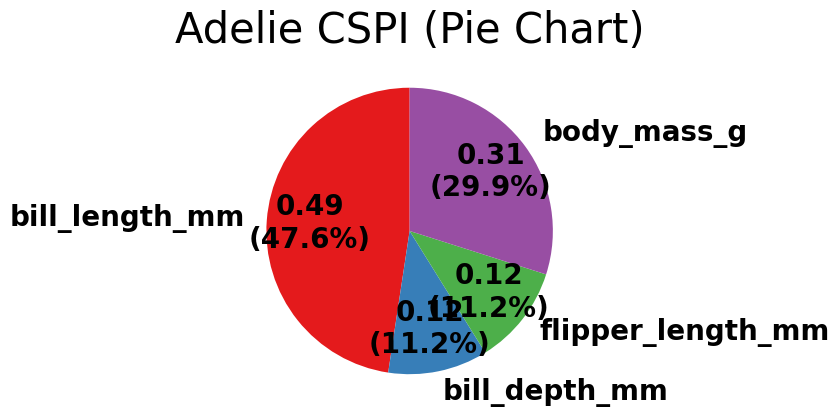

C:\Users\ochag\AppData\Local\Temp\ipykernel_10580\1696730872.py:179: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



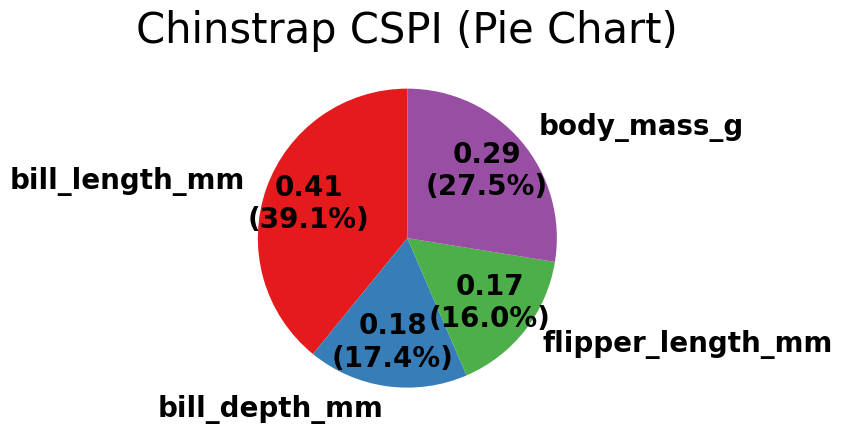

C:\Users\ochag\AppData\Local\Temp\ipykernel_10580\1696730872.py:179: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



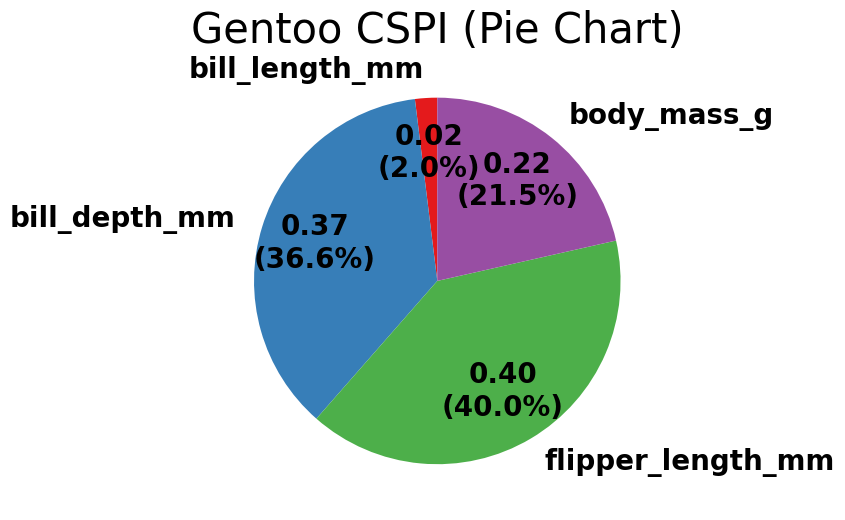

In [14]:
#クラス毎のインスタンスの平均の例
cspi.plot_waterfall_plotly(
    feature_names=feature_names,
    class_names=class_names,
    i=None,
    save_as_pdf=True,
    pdf_prefix="penguin_waterfall"
)